## Similaridade de Projetos Baseado nos itens utilizados

Lendo os dados e salvando na matriz X.
As features utilizadas neste projeto são: 
- IdPRONAC
- Item
- Quantidade(Proposta)
- Ocorrencia(Proposta)
- QtdeDias(Proposta)
- ValorUnitario(Proposta)
- Justificativa(Proposta)


In [2]:
import pandas as pd
import numpy as np

Data = pd.read_csv('Salic_Data.csv')
Data.columns = ['IdPRONAC', 'CgcCpf', 'AnoProjeto', 'Sequencial', 'idPlanilhaEtapa', 'UF', 'Municipio', 'Item', 'Unidade', 'Quantidade(Proposta)', 'Ocorrencia(Proposta)', 'QtdeDias(Proposta)', 'ValorUnitario(Proposta)', 'Justificativa(Proposta)', 'Quantidade(Projeto)', 'Ocorrencia(Projeto)', 'QtdeDias(Projeto)', 'ValorUnitario(Projeto)', 'Justificativa(Parecista)', 'Produto']

X = Data[['IdPRONAC', 'Item', 'Quantidade(Proposta)', 'Ocorrencia(Proposta)', 'QtdeDias(Proposta)', 'ValorUnitario(Proposta)', 'Justificativa(Proposta)', 'Produto']]

Variáveis úteis utilizadas ao longo do projeto

- ConjuntoDeItens    = conjunto de itens utilizados em todos os projetos.
- ConjuntoDeProjetos = lista do pronac de todos os projetos.
- featureNameToIndex = usado para converter o nome da coluna para o índex da matriz associado.

In [3]:
# FEATURE INDICES
featureNameToIndex = {featureName: index for index, featureName in enumerate(X)}




Indices_Manutencao_de_Museu  = X['Produto'] == 'Exposição de Artes'
Indices_Apresentacao_Musical = X['Produto'] == 'Apresentação Musical'

X_Selected = X[Indices_Manutencao_de_Museu | Indices_Apresentacao_Musical]


ConjuntoDeItens = list(set(X_Selected['Item']))
ConjuntoDeProjetos = list(set(X_Selected['IdPRONAC']))


####  Processamento de dados.

Agrupamento dos itens de cada projeto, considerando também a quantidade.

Criando um dicionário **pronac_itens_dict**

- Key   ->   pronac
- Value -> [item, quantidade] 

In [4]:
from collections import defaultdict
pronac_itens_dict = defaultdict(list)
X_values = X.values

for index, item  in enumerate(X_values):
    pronac_itens_dict[item[featureNameToIndex['IdPRONAC']]].append([item[featureNameToIndex['Item']], item[featureNameToIndex['Quantidade(Proposta)']]*item[featureNameToIndex['Ocorrencia(Proposta)']]*item[featureNameToIndex['QtdeDias(Proposta)']]])

#### Une itens similares e soma quantidade.
- Key   ->   pronac
- Value -> Dicionário{item, quantidade}  

In [5]:
pronac_itens_compressed_dict = {}
for key_pronac, value_itens in pronac_itens_dict.items():
    item_value_dict = {}
    for value in value_itens:
        if value[0] in item_value_dict:
            item_value_dict[value[0]] = item_value_dict[value[0]] + value[1]
        else:
            item_value_dict[value[0]] = value[1]
#     print(key_pronac)
#     print(item_value_dict)
    pronac_itens_compressed_dict[key_pronac] = item_value_dict

#### Criando matriz com todos os dados

    | Pronac 1 | Pronac 2 | Pronac 3 |
        
    |  Item 1  |  Item 1  |  Item 1  |
    |  Item 2  |  Item 2  |  Item 2  |
    |  Item 3  |  Item 3  |  Item 3  |
    ...
    


### Generating Labels

In [6]:
def buildProjetItemsArray(projectItems, allItems):
    items_arrays = np.zeros(len(allItems))
    for index, item in enumerate(allItems):
        if (item in projectItems):
            items_arrays[index] = 1
    return list(items_arrays)

def buildNormalizedProjetItemsArray(projectItems, allItems):
    items_arrays = np.zeros(len(allItems))
    for index, item in enumerate(allItems):
        if (item in projectItems):
            items_arrays[index] = 1
    #print(items_arrays)
    #items_arrays = items_arrays / sum(items_arrays)
    items_arrays = items_arrays / (sum( (item**2) for item in items_arrays))**0.5
    #print(items_arrays)
    return list(items_arrays)
            

projectsItemsMatrix = []
projectKind = []
for index, pronacID in enumerate(ConjuntoDeProjetos):  
    x = buildNormalizedProjetItemsArray(pronac_itens_compressed_dict[pronacID],ConjuntoDeItens)
    projectsItemsMatrix.append(x)
    
    projectType = X_Selected[X_Selected['IdPRONAC'] == pronacID]['Produto'].values == X_Selected['Produto'].values[0]
    projectKind.append(projectType[0])

# #     # Using less data to train faster  
    if (index == 500):
        break;

### Plotting Data

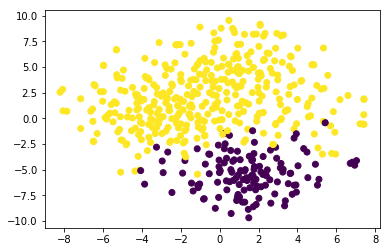

In [7]:
X = projectsItemsMatrix

import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(X)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=projectKind, cmap='viridis')

plt.show();

## Feature Selection

### Classification Algorithm

Logistic Regression

In [8]:
def classifyData(X, Y):

    from  sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import KFold
    from sklearn.metrics import confusion_matrix
    import itertools

    kf = KFold(n_splits=10, shuffle=True, random_state=5)
    kf.get_n_splits(X)

    total_confusion_matrix = [[0, 0], [0, 0]]
    #    CONFUSION MATRIX 
    #    ----------------
    #         0  1  2   <- Predicted
    #      0 [2, 0, 0]  
    # TRUE 1 [0, 0, 1]  
    #      2 [1, 0, 2] 

    for train_index, test_index in kf.split(X):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        classifier = LogisticRegression(class_weight='balanced')
        y_pred = classifier.fit(X_train, y_train).predict(X_test)

        # Compute confusion matrix
        cnf_matrix = confusion_matrix(y_test, y_pred)
        total_confusion_matrix = total_confusion_matrix + cnf_matrix

    # print(total_confusion_matrix, flush=True)
    accuracy = (total_confusion_matrix[0][0] + total_confusion_matrix[1][1]) / sum(sum(total_confusion_matrix))
    # print('Accuracy: ', accuracy)
    
    return accuracy

### Using L1-norm for feature selection

In [11]:
X = np.array(projectsItemsMatrix)
Y = np.array(projectKind)

print('** Number of original features:', X.shape[1])

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

coeficients_accuracy = []
for regCoeficient in range(1, 100):
    regCoeficient = regCoeficient/100
    lsvc = LinearSVC(C=regCoeficient, penalty="l1", dual=False).fit(X, Y)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    if (X_new.shape[1] > 0):
        print(regCoeficient)
        num_of_features = X_new.shape[1]
        print(num_of_features,' features')
        accuracy = classifyData(X_new, Y)
        coeficients_accuracy.append([regCoeficient, num_of_features, accuracy])
        print(accuracy)
#print(coeficients_accuracy)

** Number of original features: 645
0.04
1  features
0.842315369261
0.05
3  features
0.910179640719
0.06
5  features
0.910179640719
0.07
7  features
0.924151696607
0.08
8  features
0.914171656687
0.09
8  features
0.914171656687
0.1
10  features
0.924151696607
0.11
11  features
0.932135728543
0.12
11  features
0.932135728543
0.13
13  features
0.928143712575
0.14
16  features
0.940119760479
0.15
19  features
0.944111776447
0.16
21  features
0.942115768463
0.17
22  features
0.946107784431
0.18
22  features


/usr/local/lib/python3.6/site-packages/sklearn/feature_selection/base.py:80: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  UserWarning)


0.946107784431
0.19
23  features
0.946107784431
0.2
24  features
0.952095808383
0.21
26  features
0.956087824351
0.22
26  features
0.956087824351
0.23
26  features
0.956087824351
0.24
27  features
0.956087824351
0.25
32  features
0.958083832335
0.26
36  features
0.958083832335
0.27
36  features
0.958083832335
0.28
37  features
0.956087824351
0.29
42  features
0.962075848303
0.3
44  features
0.960079840319
0.31
45  features
0.958083832335
0.32
46  features
0.960079840319
0.33
46  features
0.960079840319
0.34
47  features
0.964071856287
0.35
51  features
0.97005988024
0.36
51  features
0.97005988024
0.37
52  features
0.972055888224
0.38
54  features
0.97005988024
0.39
54  features
0.97005988024
0.4
55  features
0.97005988024
0.41
57  features
0.974051896208
0.42
57  features
0.974051896208
0.43
59  features
0.976047904192
0.44
58  features
0.978043912176
0.45
58  features
0.978043912176
0.46
59  features
0.978043912176
0.47
60  features
0.976047904192
0.48
62  features
0.978043912176
0.4

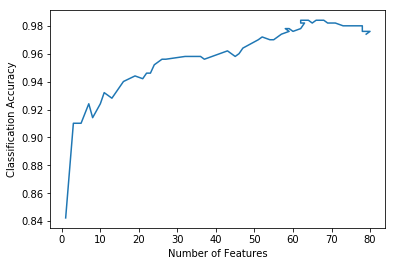

In [10]:
import matplotlib.pyplot as plt

coeficients_accuracy_np = np.array(coeficients_accuracy)
plt.plot(coeficients_accuracy_np[:,1], coeficients_accuracy_np[:,2])
plt.xlabel('Number of Features')
plt.ylabel('Classification Accuracy')
plt.show()

In [21]:
X = np.array(projectsItemsMatrix)
Y = np.array(projectKind)

print('** Number of original features:', X.shape[1])

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.5, penalty="l1", dual=False).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)

import numpy as np
np.set_printoptions(threshold=np.inf)
print(X[6,:])
X_new = model.transform(X)

X_sparse = model.inverse_transform(X_new)

print(X_sparse[6,:])

num_of_features = X_new.shape[1]
print('** Features: ', num_of_features)
accuracy = classifyData(X_new, Y)
print('** Accuracy:', accuracy)

all_items = sum(X_sparse[:])
items_used = (all_items > 0.000001)

ConjuntoDeItens_np = np.array(ConjuntoDeItens)
filtered_items = ConjuntoDeItens_np[items_used]
for item in filtered_items: 
    print(item)

** Number of original features: 645
[ 0.          0.          0.          0.          0.          0.
  0.22941573  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.22941573  0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.22941573
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.    

### Using decision Trees for feature selection

In [11]:
X = np.array(projectsItemsMatrix)
Y = np.array(projectKind)

print('** Number of original features:', X.shape[1])

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel


clf = ExtraTreesClassifier()
clf = clf.fit(X, Y)
clf.feature_importances_  
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)

print('** new number of features:', X_new.shape[1])

accuracy = classifyData(X_new, Y)
print(accuracy)

** Number of original features: 645
** new number of features: 132
0.966067864271


### Removing Features with low variance

In [12]:
# X = projectsItemsMatrix
# X = np.array(X)

# from sklearn.feature_selection import VarianceThreshold

# sel = VarianceThreshold(threshold=(0.010))
# new_X = sel.fit_transform(X)
# print(new_X.shape[1])

### Chi-squared test                                       
    ?? Pearson's chi-squared test??

In [13]:
X = np.array(projectsItemsMatrix)
Y = np.array(projectKind)

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

coeficients_accuracy = []
for num_features in range(1,100):
    X_new = SelectKBest(chi2, k=num_features).fit_transform(X, Y)
    X_new.shape[1]
    accuracy = classifyData(X_new, Y)
    coeficients_accuracy.append([num_features, accuracy])

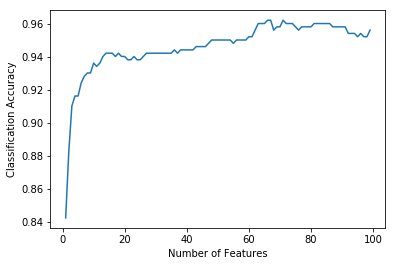

In [14]:
import matplotlib.pyplot as plt

coeficients_accuracy_np = np.array(coeficients_accuracy)
plt.plot(coeficients_accuracy_np[:,0], coeficients_accuracy_np[:,1])
plt.xlabel('Number of Features')
plt.ylabel('Classification Accuracy')
plt.show()

### Recursive Feature Elimination

Optimal number of features : 129


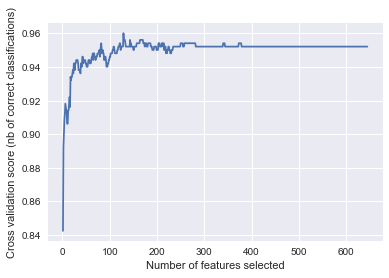

In [92]:
import matplotlib.pyplot as plt
#from sklearn.svm import SVC
from  sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

X = np.array(projectsItemsMatrix)
Y = np.array(projectKind)



# Create the RFE object and compute a cross-validated score.
#svc = SVC(kernel="linear")
log_regression = LogisticRegression(class_weight='balanced')
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=log_regression, step=1, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, Y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Supervised Algorithms

[[127   3]
 [  6 365]]
Accuracy:  0.982035928144


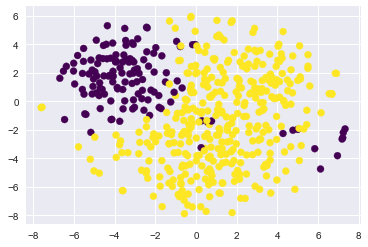

In [95]:
X = np.array(projectsItemsMatrix)
Y = np.array(projectKind)


from sklearn.svm import LinearSVC
from  sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import itertools

kf = KFold(n_splits=10, shuffle=True, random_state=5)
kf.get_n_splits(X)

total_confusion_matrix = [[0, 0], [0, 0]]
#    CONFUSION MATRIX 
#    ----------------
#            0  1  2   <- Predicted
#         0 [2, 0, 0]  
# TRUE -> 1 [0, 0, 1]  
#         2 [1, 0, 2] 


lsvc = LinearSVC(C=0.5, penalty="l1", dual=False).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
transformed_X = model.transform(X)



for train_index, test_index in kf.split(transformed_X):
    
    X_train, X_test = transformed_X[train_index], transformed_X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    
    log_reg_clf = LogisticRegression(class_weight='balanced')
    y_pred = log_reg_clf.fit(X_train,y_train).predict(X_test)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    # print(cnf_matrix)
    total_confusion_matrix = total_confusion_matrix + cnf_matrix

    #print(cnf_matrix, flush=True)
print(total_confusion_matrix, flush=True)
print('Accuracy: ', (total_confusion_matrix[0][0] + total_confusion_matrix[1][1]) / sum(sum(total_confusion_matrix)))


y_pred = log_reg_clf.predict(transformed_X)

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne_model = TSNE(perplexity=70, n_components=2, n_iter=1000, random_state=8)
y_tsne = tsne_model.fit_transform(transformed_X)

plt.scatter(y_tsne[:, 0], y_tsne[:, 1], c=y_pred, cmap='viridis')

plt.show();

### Comparing clusters with data

correct predictions:  476
wrong predictions:  25
"Accuracy":  0.950099800399


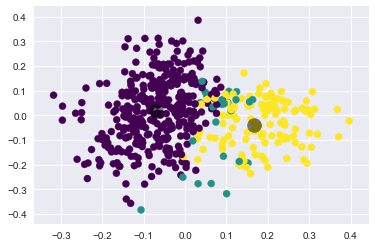

In [82]:
X = np.array(X_sparse)
Y = np.array(projectKind)

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, init='k-means++', n_init=20, random_state=8)  # random_state: 2, 5, *8*
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
kmeans_centers = kmeans.cluster_centers_

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X) 


# for (x,y) in zip(y_kmeans, Y):
#     print(x)
#     print(y)

kmeans_label_output_1 = np.array([x+y for (x,y) in zip(y_kmeans, Y)])
kmeans_label_output_2 = np.array([x-y+1 for (x,y) in zip(y_kmeans, Y)])
total_points_in_clusters_1 = len(kmeans_label_output_1[ (kmeans_label_output_1 == 0)+(kmeans_label_output_1 == 2) ])
total_points_in_clusters_2 = len(kmeans_label_output_2[ (kmeans_label_output_2 == 0)+(kmeans_label_output_2 == 2) ])
if (total_points_in_clusters_1 > total_points_in_clusters_2):
    kmeans_label_output = kmeans_label_output_1
else:
    kmeans_label_output = kmeans_label_output_2

#print(kmeans_label_output)

predictions_a = sum([x==y for (x,y) in zip(y_kmeans, Y)])
predictions_b = sum([not x==y for (x,y) in zip(y_kmeans, Y)])
correct_predictions = max(predictions_a, predictions_b)
wrong_predictions = min(predictions_a, predictions_b)
print('correct predictions: ',correct_predictions)
print('wrong predictions: ',wrong_predictions)
print('"Accuracy": ',correct_predictions / (correct_predictions+wrong_predictions))

plt.scatter(x_pca[:, 0], x_pca[:, 1], c=kmeans_label_output, s=50, cmap='viridis')


centers_pca = pca.transform(kmeans_centers)


plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='black', s=200, alpha=0.5);

plt.show();

In [ ]:
X = np.array(projectsItemsMatrix)
Y = np.array(projectKind)

print('** Number of original features:', X.shape[1])

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

coeficients_accuracy = []
for regCoeficient in range(1, 100):
    regCoeficient = regCoeficient/100
    lsvc = LinearSVC(C=regCoeficient, penalty="l1", dual=False).fit(X, Y)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    if (X_new.shape[1] > 0):
        print(regCoeficient)
        num_of_features = X_new.shape[1]
        print(num_of_features,' features')
        accuracy = classifyData(X_new, Y)
        coeficients_accuracy.append([regCoeficient, num_of_features, accuracy])
        print(accuracy)
#print(coeficients_accuracy)